# QLoRA with HuggingFace


QLoRA is an extension of LoRA that leverages quantization. Quantization is the process of mapping continuous infinite values to a smaller set of discrete finite values. Effectively, the model's parameters are are stored in 2, 3, 4 or 8-bits as opposed to the usual 32-bits, lowering the number of bits needed to store information. Quantization offers two benefits:

1. It reduced memory footprint. By using a finite set of discrete levels, the values can be represented with fewer bits, reducing the memory required to store them; and
2. It allows for efficient computation. Quantized values can be represented and processed more efficiently on hardware with limited numerical precision, such as low-power microcontrollers or specialized AI/ML accelerators.

Choosing QLoRA over LoRA provides several tradeoffs. QLoRA offers the following advantages of LoRA:

1. Substantially smaller GPU memory usage than LoRA.
2. Higher maximum sequence lengths resulting from the smaller GPU memory usage.
3. Higher batch sizes resulting from the smaller GPU memory usage.

The main disadvantage of QLoRA is slower fine-tuning speed.

Interestingly enough, the accuracy of QLoRA and LoRA are comparable despite the fact that QLoRA offers substantially smaller models with lower GPU memory footprints than LoRA.

The original QLoRA paper is available [here](https://arxiv.org/pdf/2305.14314).


**Note that the following uses the popular `BitsAndBytes` library to implement QLoRA, which only supports quantization using a CUDA-enabled GPU. You will not be able to run this notebook without a compatible GPU!**

# __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Install-required-libraries">Install required libraries</a></li>
            <li><a href="#Import-required-libraries">Import required libraries</a></li>
            <li><a href="#Define-helper-functions">Define helper functions</a></li>
        </ol>
    </li>
    <li><a href="#IMDB-dataset">IMDB dataset</a></li>
    <li><a href="#Tokenizer">Tokenizer</a></li>
    <li><a href="#Configure-BitsAndBytes">Configure BitsAndBytes</a></li>
    <li><a href="#Load-a-quantized-version-of-a-pretrained-model">Load a quantized version of a pretrained model</a></li>
    <li><a href="#Train">Train</a></li>
    <li><a href="#Results">Results</a></li>
</ol>


---


# Objectives

After completing this lab you will be able to:

- Load and predict using models from HuggingFace
- Fine-tune language models using QLoRA
- Understand the advantages and disadvantages of QLoRA



---


# Setup


### Install required libraries

For this lab, you use the following libraries, which are __not__ preinstalled in the Skills Network Labs environment. __You must run the code in the following cell__ to install them.


In [ ]:
!pip install -U \
datasets \
huggingface_hub \
transformers \
peft \
bitsandbytes \
matplotlib \
scikit-learn \
triton \
evaluate

### Import required libraries

The following code imports required libraries.


In [ ]:
import torch
import matplotlib.pyplot as plt
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import json

import numpy as np

from datasets import load_dataset
from evaluate import load as load_metric

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig

from peft import LoraConfig, get_peft_model, TaskType, replace_lora_weights_loftq, prepare_model_for_kbit_training

### Define helper functions

Here are some helper functions. We will use these later to save and load from JSON:


In [ ]:
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")


def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

# IMDB dataset

The IMDB dataset is a large movie review dataset, consisting of 50,000 movie reviews for training and 25,000 movie reviews for testing. The reviews are labeled as either positive or negative, and each review is a variable-length sequence of words. The IMDB dataset is a popular benchmark for text classification tasks, and it has been used to train a variety of natural language processing models. The following line loads the IMDB dataset:


In [ ]:
imdb = load_dataset("imdb")

Let's display the structure of the IMDB dataset:


In [ ]:
# Display the structure of the dataset
print("Dataset structure:")
print(imdb)

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


The following displays the available splits in the dataset (train, test, unsupervised)


In [ ]:
imdb.keys()

dict_keys(['train', 'test', 'unsupervised'])

Let's explore and print a sample from the training set:


In [ ]:
# Explore and print a sample from the training set
print("\nSample from the training set:")
print(imdb['train'][0])


Sample from the training set:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and n

The followiong displays the unique class labels in the dataset. For the IMDB dataset, the labels are integers representing sentiment, where 0 stands for “negative” and 1 stands for “positive”. Here’s how you can extract this information:


In [ ]:
train_labels = imdb['train']['label']
unique_labels = set(train_labels)
print("\nUnique labels in the dataset (class information):")
print(unique_labels)


Unique labels in the dataset (class information):
{0, 1}


The following dictionary maps class values to class names:


In [ ]:
class_names = {0: "negative", 1: "positive"}
class_names

{0: 'negative', 1: 'positive'}

Since the IMDB dataset is quite large, we’ll create smaller subsets to facilitate quicker training and testing.

In this notebook, we simulate training and testing using the `small_` datasets due to time constraints. However, it's important to recognize that these smaller datasets are insufficient for proper fine-tuning of the BERT model. For more accurate results, a larger subsample, such as the `medium_train_dataset`, would be necessary.

Consequently, all results presented here pertain to models trained with the `medium_train_dataset` and evaluated on the test set from `medium_test_dataset`. However, the notebook, as is, does NOT train models on these datasets; rather, it trains models using the `small_` datasets, as training on the `medium_` datasets would be too time-consuming.


In [ ]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(50))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(50))])
medium_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
medium_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

# Tokenizer

The following loads the DistilBERT tokenizer:    


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

The tokenizer provides tokenized input IDs and an attention mask for a given input text:


In [ ]:
my_tokens=tokenizer(imdb['train'][0]['text'])

# Print the tokenized input IDs
print("Input IDs:", my_tokens['input_ids'])

# Print the attention mask
print("Attention Mask:", my_tokens['attention_mask'])

# If token_type_ids is present, print it
if 'token_type_ids' in my_tokens:
    print("Token Type IDs:", my_tokens['token_type_ids'])

Input IDs: [101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026, 2678, 3573, 2138, 1997, 2035, 1996, 6704, 2008, 5129, 2009, 2043, 2009, 2001, 2034, 2207, 1999, 3476, 1012, 1045, 2036, 2657, 2008, 2012, 2034, 2009, 2001, 8243, 2011, 1057, 1012, 1055, 1012, 8205, 2065, 2009, 2412, 2699, 2000, 4607, 2023, 2406, 1010, 3568, 2108, 1037, 5470, 1997, 3152, 2641, 1000, 6801, 1000, 1045, 2428, 2018, 2000, 2156, 2023, 2005, 2870, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 5436, 2003, 8857, 2105, 1037, 2402, 4467, 3689, 3076, 2315, 14229, 2040, 4122, 2000, 4553, 2673, 2016, 2064, 2055, 2166, 1012, 1999, 3327, 2016, 4122, 2000, 3579, 2014, 3086, 2015, 2000, 2437, 2070, 4066, 1997, 4516, 2006, 2054, 1996, 2779, 25430, 14728, 2245, 2055, 3056, 2576, 3314, 2107, 2004, 1996, 5148, 2162, 1998, 2679, 3314, 1999, 1996, 2142, 2163, 1012, 1999, 2090, 4851, 8801, 1998, 6623, 7939, 4697, 3619, 1997, 8947, 2055, 2037, 10740, 2006, 4331, 1010, 2016, 2038, 3348, 2007, 2014, 3689, 3836, 

The following preprocessing function tokenizes a text input. We apply this function to all texts in our datasets using the `.map()` method:


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=512)

small_tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
small_tokenized_test = small_test_dataset.map(preprocess_function, batched=True)
medium_tokenized_train = medium_train_dataset.map(preprocess_function, batched=True)
medium_tokenized_test = medium_test_dataset.map(preprocess_function, batched=True)

Run the following to see what a sample from the tokenized dataset looks like. Note that this dataset is identical to the original, with just the token indices and attention mask appended.


In [ ]:
print(small_tokenized_train[49])

{'text': 'With no affinity towards any type of filmmaking, and a healthy appreciation of documentaries, I can honestly say I was angry at myself for bothering to sit through the entire length of "20 Dates". I won\'t waste your time with the plot, you may read other reviews. I will say though that Berkowitz\'s hyper, Woody Allen-style narration was extremely annoying. You either wished he\'d lay off the coffee or ingest some tranquilizers. And it\'s potentially apparent to Berkowitz himself that this film was a bad idea, as parts of it details his trials to finance the documentary. Forgive me for disguising insults as compliments, but I\'ll give credit to Berkowitz for having the skills to convince some idiot to finance this horrid piece of ****. I appreciate the boundaries & intentions of the film here, but even when regarding the standards Berkowitz sets for himself, he fires off and misses on all levels. In closing, I\'m sure many of these female companions were not at ease going on 

The following defines the `compute_metrics` funcion to evaluate model performance using accuracy:


In [ ]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy", trust_remote_code=True)


   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

   return {"accuracy": accuracy}


---


# Configure BitsAndBytes


The following code creates a `BitsAndBytes` config object where we define the quantization parameters. Every line in that config is commented to inform you of its function:


In [ ]:
config_bnb = BitsAndBytesConfig(
    load_in_4bit=True, # quantize the model to 4-bits when you load it
    bnb_4bit_quant_type="nf4", # use a special 4-bit data type for weights initialized from a normal distribution
    bnb_4bit_use_double_quant=True, # nested quantization scheme to quantize the already quantized weights
    bnb_4bit_compute_dtype=torch.bfloat16, # use bfloat16 for faster computation
    llm_int8_skip_modules=["classifier", "pre_classifier"] #  Don't convert the "classifier" and "pre_classifier" layers to 8-bit
)

# Load a quantized version of a pretrained model


The following code creates two lists. The first list (`id2label`) maps ids to text labels for the two classes in this problem, and the second list (`label2id`) swaps the keys and the values to map the text labels to the ids:


In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = dict((v,k) for k,v in id2label.items())

The following instantiates an `AutoModelForSequenceClassification` from a pre-trained `bert-base-uncased` model using the `BitsAndBytesConfig` defined above and the id to label and label to id mappings. The `quantization_config` parameter in particular indicates that a quantized version of the model should be loaded, with the quantization settings contained in the config object passed to `quantization_config`


In [ ]:
model_qlora = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased",
                                                                 id2label=id2label,
                                                                 label2id=label2id,
                                                                 num_labels=2,
                                                                 quantization_config=config_bnb,
                                                                 device_map="auto"
                                                                )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`model_qlora` is now a quantized instance of the model, but the model is not ready for quantized training just yet. This is accomplished by passing the model through the `prepare_model_for_kbit_training()` function:


In [ ]:
model_qlora = prepare_model_for_kbit_training(model_qlora)

Despite its name, `model_qlora` is not a LoRA or QLoRA object yet, but a quantized instance of a pre-trained `bert-base-uncased` model that has been made ready for quantized training. To allow this model to be fine-tuned using QLoRA, we must convert the linear layers into LoRA layers. This is done analogously to the way LoRA is applied to a non-quantized model:


In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Specify the task type as sequence classification
    r=8,  # Rank of the low-rank matrices
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,  # Dropout rate
    target_modules=['query','key','value'] # which modules
)

peft_model_qlora = get_peft_model(model_qlora, lora_config)

`peft_model_qlora` is now a QLoRA model which we can go ahead and train. However, before doing so, we will perform one other optimization: we will reinitialize the LoRA weights using LoftQ, which has been shown to improve performance when training quantized models. You can find information about LoftQ [here](https://arxiv.org/abs/2310.08659).


In [ ]:
replace_lora_weights_loftq(peft_model_qlora)

Let's print out the model summary:


In [ ]:
print(peft_model_qlora)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      

As you can see, the `bert-base-uncased` model adapted for QLoRA fine-tuning has a similar structure to the non-quantized LoRA model derived from `bert-base-uncased`. The key difference in the structure's summary is the conversion of some of the `Linear` layers into `Linear4bit` layers, which are 4-bit linear layers that use blockwise k-bit quantization under the hood.


In [ ]:
peft_model_qlora.print_trainable_parameters()

trainable params: 443,906 || all params: 109,927,684 || trainable%: 0.4038


As can be seen above, fine-tuning the `bert-base-uncased` model using QLoRA with a rank of 8 results in just 0.4% of the resulting parameters being trainable.


# Train


Fine-tuning the QLoRA model from this point on is identical to fine-tuning a LoRA model. First, define the training arguments:


In [ ]:
training_args = TrainingArguments(
    output_dir="./results_qlora",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    eval_strategy="epoch",
    weight_decay=0.01
)

Then, train the model using `Trainer`:


In [ ]:
trainer_qlora = Trainer(
    model=peft_model_qlora,
    args=training_args,
    train_dataset=medium_tokenized_train,
    eval_dataset=medium_tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)


trainer_qlora.train(resume_from_checkpoint="./results_qlora/checkpoint-1000")

wandb: Currently logged in as: mayank1996-skb (mayank1996skb) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
6,0.526500,0.451411,0.793333
7,0.526500,0.427657,0.806667
8,0.380800,0.415296,0.816667
9,0.380800,0.407732,0.823333
10,0.380800,0.406620,0.826667


TrainOutput(global_step=1880, training_loss=0.1712650867218667, metrics={'train_runtime': 2149.6911, 'train_samples_per_second': 13.955, 'train_steps_per_second': 0.875, 'total_flos': 7972534150594560.0, 'train_loss': 0.1712650867218667, 'epoch': 10.0})

You can save a trained QLoRA model using the following:


In [ ]:
trainer_qlora.save_model("./qlora_final_model")

# Results


To analyze how training progresses with each epoch, you can also extract the log history:


In [ ]:
log_history_qlora = trainer_qlora.state.log_history

This log history can be used to calculate our accuracy metric using the following `lambda` function:


In [ ]:
get_metric_qlora = lambda metric, log_history_qlora: [log[metric] for log in log_history_qlora if metric in log]

And this function can, in turn, be used to plot what happens to the evaluation loss and accuracy during training:


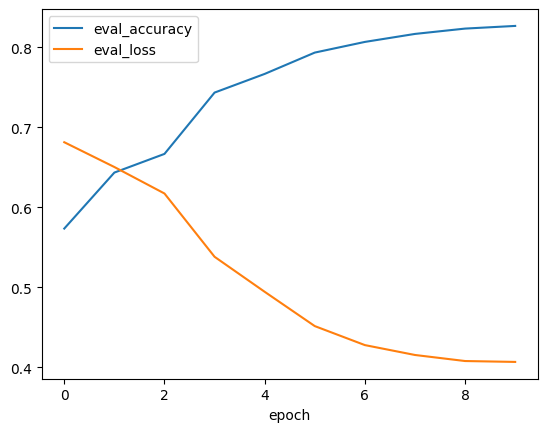

In [ ]:
eval_accuracy_qlora=get_metric_qlora('eval_accuracy',log_history_qlora)
eval_loss_qlora=get_metric_qlora('eval_loss',log_history_qlora)
plt.plot(eval_accuracy_qlora,label='eval_accuracy')
plt.plot(eval_loss_qlora,label='eval_loss')
plt.xlabel("epoch")
plt.legend()

The above code indicates that, in this particular instance, the bulk of the benefits from fine-tuning were gained within the first 3 epochs.


---


# LORA Training

Compare the training time and validation accuracy of QLoRA and LoRA models.

## Load the pretrained model for lora

Load a non-quantized version of the pre-trained model that is suitable for LoRA fine-tuning.

**Reasoning**:
Instantiate AutoModelForSequenceClassification for LoRA fine-tuning.




In [ ]:
model_lora = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased",
                                                                id2label=id2label,
                                                                label2id=label2id,
                                                                num_labels=2,
                                                                device_map="auto"
                                                               )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Prepare the model for lora training

Convert the appropriate layers of the model to LoRA layers using the PEFT library.

**Reasoning**:
Define the LoRA configuration and apply it to the non-quantized model to create a PEFT model for LoRA fine-tuning. Then, print the trainable parameters to confirm the changes.



In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Specify the task type as sequence classification
    r=8,  # Rank of the low-rank matrices
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,  # Dropout rate
    target_modules=['query','key','value'] # which modules
)

peft_model_lora = get_peft_model(model_lora, lora_config)
peft_model_lora.print_trainable_parameters()

trainable params: 443,906 || all params: 109,927,684 || trainable%: 0.4038


## Define training arguments for lora

Set up the training parameters for the LoRA model.

**Reasoning**:
Instantiate the TrainingArguments class with the specified parameters.



In [ ]:
training_args_lora = TrainingArguments(
    output_dir="./results_lora",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    eval_strategy="epoch",
    weight_decay=0.01
)

## Train the lora model

Train the LoRA model using the prepared dataset and training arguments.

**Reasoning**:
Train the LoRA model using the prepared dataset and training arguments.



In [37]:
trainer_lora = Trainer(
    model=peft_model_lora,
    args=training_args_lora,
    train_dataset=medium_tokenized_train,
    eval_dataset=medium_tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_lora.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.685093,0.580000
2,No log,0.665047,0.610000
3,0.681900,0.619789,0.746667
4,0.681900,0.514967,0.780000
5,0.681900,0.403668,0.823333
6,0.514100,0.368603,0.836667
7,0.514100,0.362941,0.846667
8,0.324400,0.358300,0.856667


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.685093,0.580000
2,No log,0.665047,0.610000
3,0.681900,0.619789,0.746667
4,0.681900,0.514967,0.780000
5,0.681900,0.403668,0.823333
6,0.514100,0.368603,0.836667
7,0.514100,0.362941,0.846667
8,0.324400,0.358300,0.856667
9,0.324400,0.354427,0.856667
10,0.324400,0.353942,0.856667


TrainOutput(global_step=1880, training_loss=0.46668993361452793, metrics={'train_runtime': 2386.1899, 'train_samples_per_second': 12.572, 'train_steps_per_second': 0.788, 'total_flos': 7934242037760000.0, 'train_loss': 0.46668993361452793, 'epoch': 10.0})

## Extract log history for lora

Extract the log history from the LoRA trainer.

In [38]:
log_history_lora = trainer_lora.state.log_history

## Compare results

Plot the evaluation accuracy and loss for both LoRA and QLoRA models.

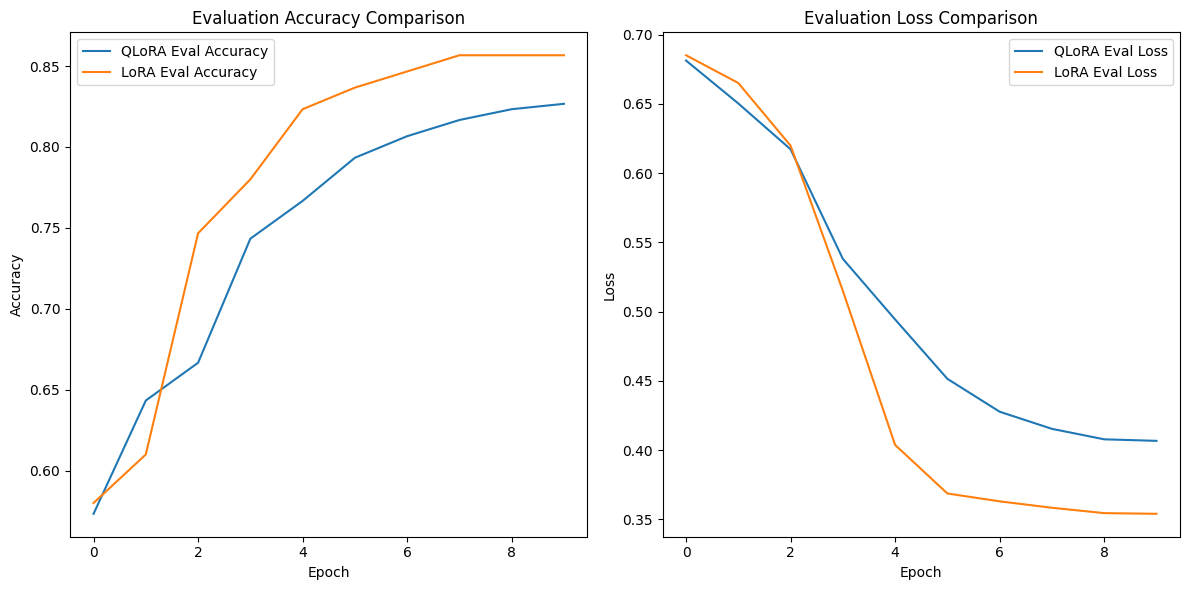

In [39]:
eval_accuracy_lora = get_metric_qlora('eval_accuracy', log_history_lora)
eval_loss_lora = get_metric_qlora('eval_loss', log_history_lora)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(eval_accuracy_qlora, label='QLoRA Eval Accuracy')
plt.plot(eval_accuracy_lora, label='LoRA Eval Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy Comparison")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_loss_qlora, label='QLoRA Eval Loss')
plt.plot(eval_loss_lora, label='LoRA Eval Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evaluation Loss Comparison")
plt.legend()

plt.tight_layout()
plt.show()

# Comparision Results

## Performance Comparison: LoRA vs. QLoRA

Based on the training conducted with the `medium_train_dataset` and evaluated on the `medium_test_dataset`, here's a comparison of the performance between LoRA and QLoRA:

**Training Time:**

*   **QLoRA:** The training runtime was approximately **2149.69 seconds**.
*   **LoRA:** The training runtime was approximately **2386.19 seconds**.

In this experiment, QLoRA was slightly faster than LoRA.

**Evaluation Accuracy and Loss:**

The generated plots show the evaluation accuracy and loss over the 10 training epochs.

*   Both QLoRA and LoRA show an increase in evaluation accuracy and a decrease in evaluation loss over the epochs, indicating that both methods are effective in fine-tuning the model for the sentiment classification task.
*   The final evaluation accuracy and loss values from the plots appear to be comparable for both methods, suggesting that despite the quantization, QLoRA achieves similar performance to LoRA on this dataset and task.

**Trainable Parameters:**

*   Both QLoRA and LoRA resulted in a similar percentage of trainable parameters (approximately 0.4038%) compared to the total parameters of the base model, highlighting the parameter-efficient nature of both techniques.

**Summary:**

In this specific experiment using the `medium_` datasets for a limited number of epochs, QLoRA demonstrated a slight advantage in training speed while achieving comparable evaluation accuracy and loss to LoRA. This aligns with the theoretical benefits of QLoRA in reducing memory footprint and potentially leading to faster training, especially with larger models and datasets. However, as noted earlier in the notebook, these datasets are relatively small for proper fine-tuning, and performance might differ on larger datasets and with more extensive training.

# Congratulations! You have completed the lab


## References

[Finetuning with LoRA -- A Hands-On Example](https://lightning.ai/lightning-ai/studios/code-lora-from-scratch)

[QLORA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/pdf/2305.14314)

[Making LLMs even more accessible with bitsandbytes, 4-bit quantization and QLoRA](https://huggingface.co/blog/4bit-transformers-bitsandbytes)
